## Speech and Speaker Recognition - DT2119 VT19-1 

### Feature Extraction - Lab 1

In [215]:
from __future__ import print_function

import numpy as np
import math

from lab1_tools import lifter,trfbank
from lab1_tools import trfbank
from lab1_tools import tidigit2labels

from scipy.signal import lfilter, hamming
from scipy.fftpack import fft
from sklearn.mixture import GaussianMixture
from scipy.fftpack.realtransforms import dct
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage,dendrogram

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
example = np.load('lab1_example.npz')['example'].item()
for x in example.keys(): print(x, end = '\t')

mspec	windowed	mfcc	preemph	samplingrate	samples	frames	lmfcc	spec	

In [3]:
data = np.load('lab1_data.npz')['data']
for x in data[0]: print(x, end = '\t')

digit	gender	filename	samplingrate	speaker	samples	repetition	

## lab1_proto.py - Functions implemented

### 4.1 Enframe

In [4]:
def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    
    no_windows_to_fit = float(np.abs(len(samples) - winlen)) / winshift
    N = int(np.ceil(no_windows_to_fit))
    frames = np.empty((N, winlen))
    
    for i in range(frames.shape[0]):
        n = i * winshift
        frames[i,:] = samples[n:n+winlen]
    
    return frames

 Given winlen = 20 milli seconds
       winshift = 10 milli seconds       
 Sampling rate = 20,000  
 i.e 20000 frames per second or 1000 milli seconds  
 i.e we have 20 frames for each micro second  
 hence the winlen and winshift in similar units of samples would be   
 20*winlen(ms) and 20*winshift(ms)  
 Giving us winlen = 400 and winshift = 200  

In [5]:
frames = enframe(example["samples"], winlen = 400, winshift = 200)

EnFrames  ✓


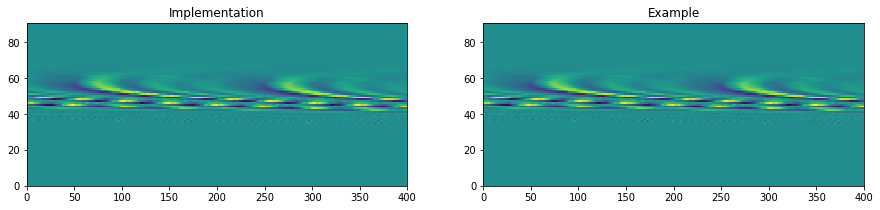

In [6]:
if np.array_equal(frames, example["frames"]):
    print("EnFrames ", u'\u2713')
    
#to avoid wanted output strings in the console use _ =
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(121).set_title("Implementation")
_ = plt.pcolormesh(frames)
_ = plt.subplot(122).set_title("Example")
_ = plt.pcolormesh(example["frames"])

### 4.2  Pre-emphasis

From lecture what pre-emph need to do  
##### y[n] = x[n] − αx[n − 1]  
what lfilter does  
scipy.signal.lfilter(b, a, x, axis=-1, zi=None)  
##### a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]           - a[1]*y[n-1] - ... - a[N]*y[n-N]  
Here b would be 1,-alpha  
a would be 1 and a1-n would be 0  
x would be the frame  

In [7]:
def preemp(input, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """    
    b = [1,-p]
    a = [1]
    return lfilter(b, a, input)

Pre-emphasis  ✓


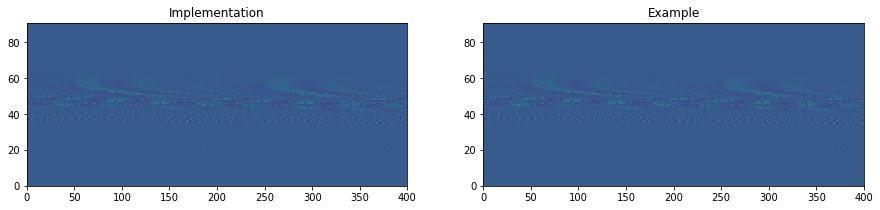

In [8]:
preemph = []
for x in frames:
    preemph.append(preemp(x))

preemph = np.asarray(preemph)

if np.array_equal(preemph, example["preemph"]):
    print("Pre-emphasis ", u'\u2713')
    
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(121).set_title("Implementation")
_ = plt.pcolormesh(preemph)
_ = plt.subplot(122).set_title("Example")
_ = plt.pcolormesh(example["preemph"])

### 4.3 Hamming Window

##### Why windowing -
When we perform FFT over waveform a noninteger number of cycles, this discountinuity in waveform shows up as a high frequency which is not actually present in the original waveform. To minimize the effects of performing an FFT over waveforms of a noninteger number of cycles we use windowing

In [173]:
def windowing(input):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windoed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    n_frames = input.shape[1]
    hamming_window = hamming(n_frames, sym=False)
   
    #uncomment to display window
    #_ = plt.rcParams['figure.figsize'] = [5, 3]
    #plt.plot(hamming_window)
    #plt.show()
    
    windowed = input * hamming_window
    return windowed

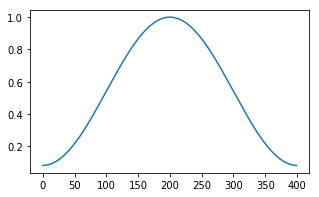

Hamming Window  ✓


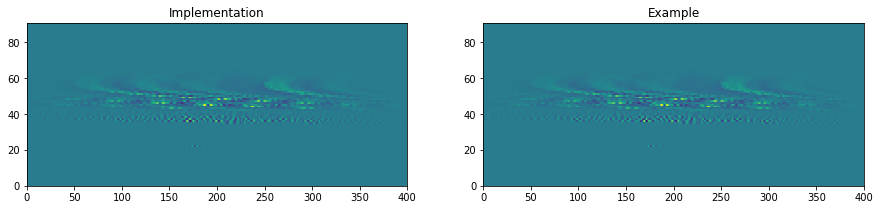

In [167]:
windowed = windowing(preemph)
if np.array_equal(windowed, example["windowed"]):
    print("Hamming Window ", u'\u2713')
    
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(121).set_title("Implementation")
_ = plt.pcolormesh(windowed)
_ = plt.subplot(122).set_title("Example")
_ = plt.pcolormesh(example["windowed"])

### 4.4 Fast Fourier Transform

In [179]:
def powerSpectrum(input, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """
    fftransform = fft(input, nfft)
    spec = np.square(np.absolute(fftransform))
    return spec

(17975.54463299129+1242.8649772780952j)
Power Spectrum  ✓


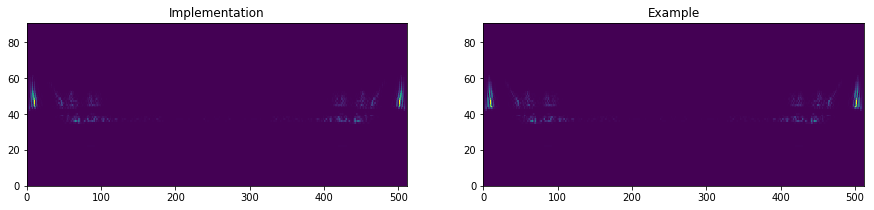

In [12]:
spec = powerSpectrum(windowed, 512)
if np.array_equal(spec, example["spec"]):
    print("Power Spectrum ", u'\u2713')
    
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(121).set_title("Implementation")
_ = plt.pcolormesh(spec)
_ = plt.subplot(122).set_title("Example")
_ = plt.pcolormesh(example["spec"])

#### Fmax = Fs/2 = 20,000/2 = 10000Hz

### 4.5 Mel filterbank log spectrum

In [170]:
def logMelSpectrum(input, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """
    
    filter_bank = trfbank(samplingrate, input.shape[1])
    #uncomment to display filter bank plots
    
#     _ = plt.rcParams['figure.figsize'] = [15, 3]
#     _ = plt.subplot(211)
#     _ = plt.plot(filter_bank)
#     _ = plt.subplot(212)
#     _ = plt.plot(filter_bank.T)
#     plt.show()

    #too much variation from the example
    #without doing this there were only handful of variations from example
    #filter_bank = np.where(filter_bank == 0, np.finfo(float).eps, filter_bank)  # Numerical Stability
    return np.log(input.dot(filter_bank.T))

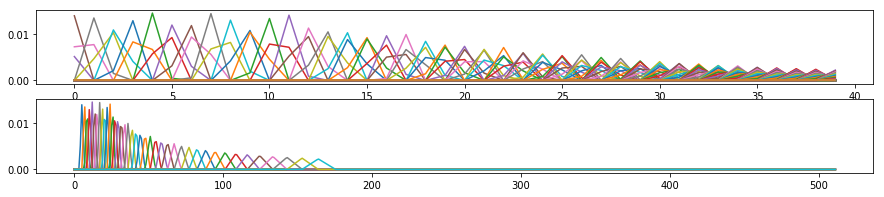

(91, 40)
Mel Filterbank Log spectrum  ✓


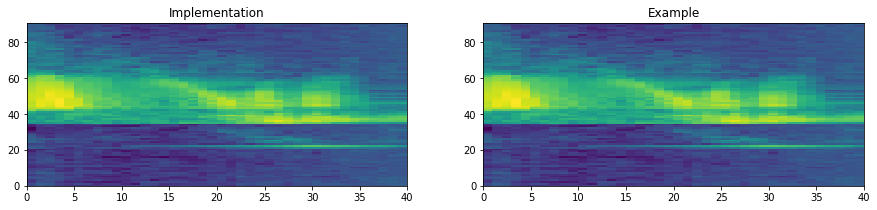

In [136]:
mspec = logMelSpectrum(example["spec"], samplingrate=20000)
#use np.allclose instead of array_equal due to variation of log usage
print(mspec.shape)
if np.allclose(mspec, example["mspec"]):
    print("Mel Filterbank Log spectrum ", u'\u2713')
else:
    print("SOMETHING SEEMS WRONG")
    print(np.unique(mspec - example["mspec"]))
    
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(121).set_title("Implementation")
_ = plt.pcolormesh(mspec)
_ = plt.subplot(122).set_title("Example")
_ = plt.pcolormesh(example["mspec"])
plt.show()
#to break the plot and start the next
# error = example["mspec"] - mspec
# _ = sns.heatmap(error)

There is inifinitesimally small variation between the example and the implementation in the order or 1e-15/1e-16 which is negligable and could happen only in the calculation of the log()

The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies

Filter Banks: Amplitude of the filters decreases. The traingles tend to stay at lower frequencies at the beginning and move towards higher frequencies

### 4.6 Cosine Transofrm and Liftering

In [96]:
def cepstrum(input, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform
    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    mfcc = dct(input)[:,0:nceps]
    return mfcc

MFCC ✓
LMFCC ✓


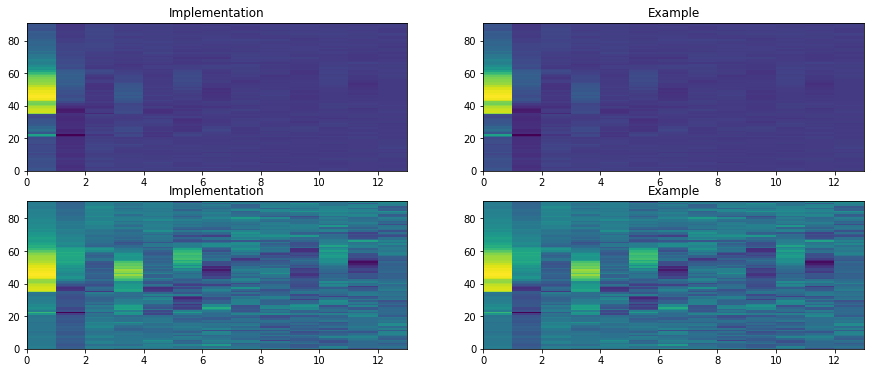

In [101]:
mfcc = cepstrum(example["mspec"], 13)
lmfcc = lifter(mfcc)

if np.allclose(mfcc, example["mfcc"]):
    print("MFCC", u'\u2713')
else:
    print("SOMETHING SEEMS WRONG")

if np.allclose(lmfcc, example["lmfcc"]):
    print("LMFCC", u'\u2713')
else:
    print("SOMETHING SEEMS WRONG")

_ = plt.rcParams['figure.figsize'] = [15, 6]
_ = plt.subplot(221).set_title("Implementation")
_ = plt.pcolormesh(mfcc)
_ = plt.subplot(222).set_title("Example")
_ = plt.pcolormesh(example["mfcc"])
_ = plt.subplot(223).set_title("Implementation")
_ = plt.pcolormesh(lmfcc)
_ = plt.subplot(224).set_title("Example")
_ = plt.pcolormesh(example["lmfcc"])

plt.show()

In [102]:
a=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
b1 = dct(a)
b2 = dct(a, n=5)
print(b1)
print(b2)

[10.          6.39245322  0.         -2.20268926  0.          1.41421356
  0.         -1.12232624  0.          1.01246513]
[10.  0.  0.  0.  0.]


#### In b2 i.e dct with parameter, all elements excepth the firsta are zero. <br> This means the input is truncated to the first 5 elements. <br> As all of them are 1 the dct for other elements are 0  

In [103]:
# DT2119, Lab 1 Feature Extraction

# Function given by the exercise ----------------------------------
def mspecFn(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    """Computes Mel Filterbank features.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        samplingrate: sampling rate of the original signal

    Returns:
        N x nfilters array with mel filterbank features (see trfbank for nfilters)
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

In [157]:
def mfccFn(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    """Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    mspec = mspecFn(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspec, nceps)
    return lifter(ceps, liftercoeff)

In [238]:
%%capture
mfccs = []
for i in range(len(data)):
    samples = data[i]['samples']
    mfccs.append(mfccFn(samples))
#make list to array
mfccs = np.concatenate(mfccs)

In [239]:
print(mfccs.shape)

(3883, 13)


### 5. Feature Correlation

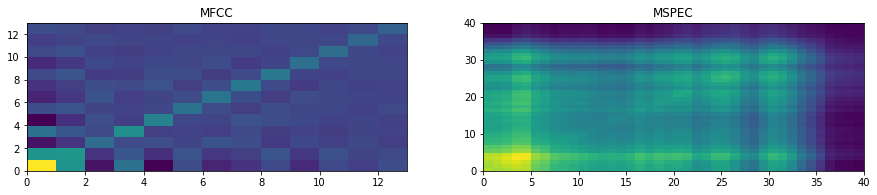

In [141]:
covs = np.cov(mfccs.T)

_ = plt.rcParams['figure.figsize'] = [15, 6]
_ = plt.subplot(221).set_title("MFCC")
_ = plt.pcolormesh(covs)
_ = plt.subplot(222).set_title("MSPEC")
_ = plt.pcolormesh(np.cov(mspec.T))

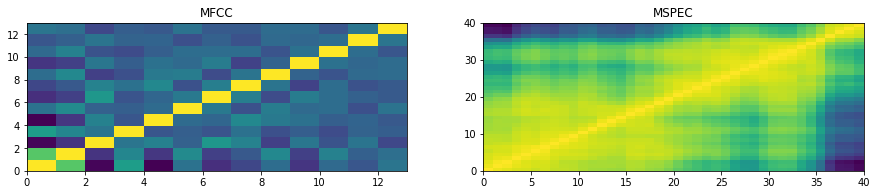

In [139]:
corrcoef = np.corrcoef(mfccs.T)

_ = plt.rcParams['figure.figsize'] = [15, 6]
_ = plt.subplot(221).set_title("MFCC")
_ = plt.pcolormesh(corrcoef)
_ = plt.subplot(222).set_title("MSPEC")
_ = plt.pcolormesh(np.corrcoef(mspec.T))

#### It is pretty clear that the samples are very distinct in MFCC's features than in MSPEC. Hence we prefer MFCC over MSPEC 

### 6 Explore Speech Segments with Clustering

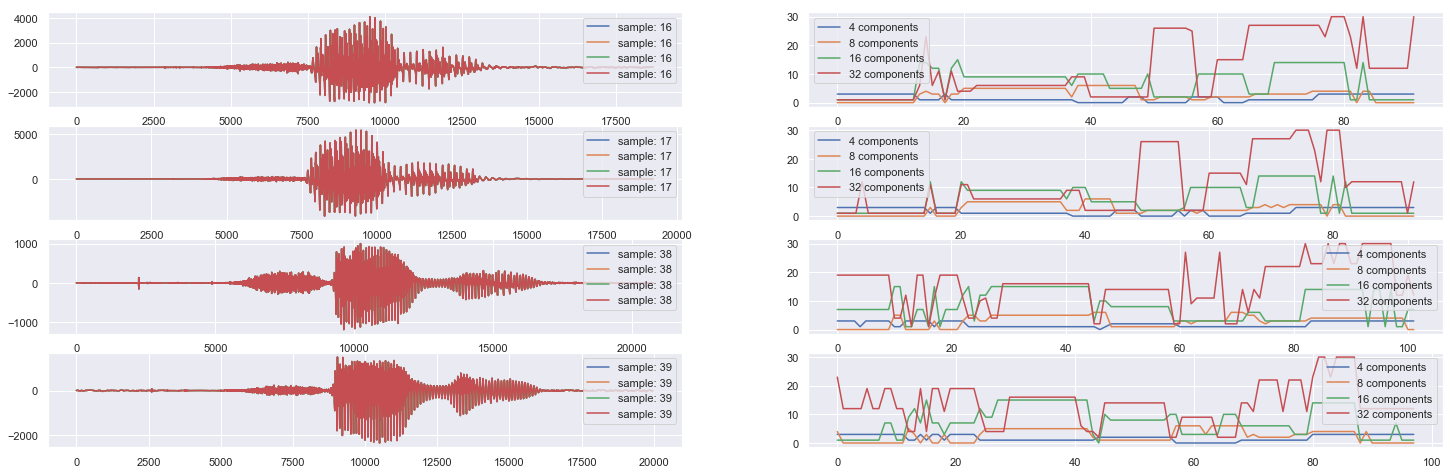

In [195]:
sns.set()
for n_components in [4,8,16,32]:
    gmm = GaussianMixture(n_components = n_components)
    _ = gmm.fit(mfccs)
    i = 1
    _ = plt.rcParams['figure.figsize'] = [25, 8]
    for k in [16,17,38,39]:
        
        ax = plt.subplot(4, 2, i)
        _ = plt.plot(data[k]['samples'], label='sample: %s' % k)
        _ = ax.legend()
        
        mfcc = mfccFn(data[k]['samples'])
        predict = gmm.predict(mfcc)
        ax = plt.subplot(4, 2, i+1)
        labels = tidigit2labels([data[k]])
        _ = plt.plot(predict, label='%s components' % n_components)
        _ = ax.legend()
        
        i += 2

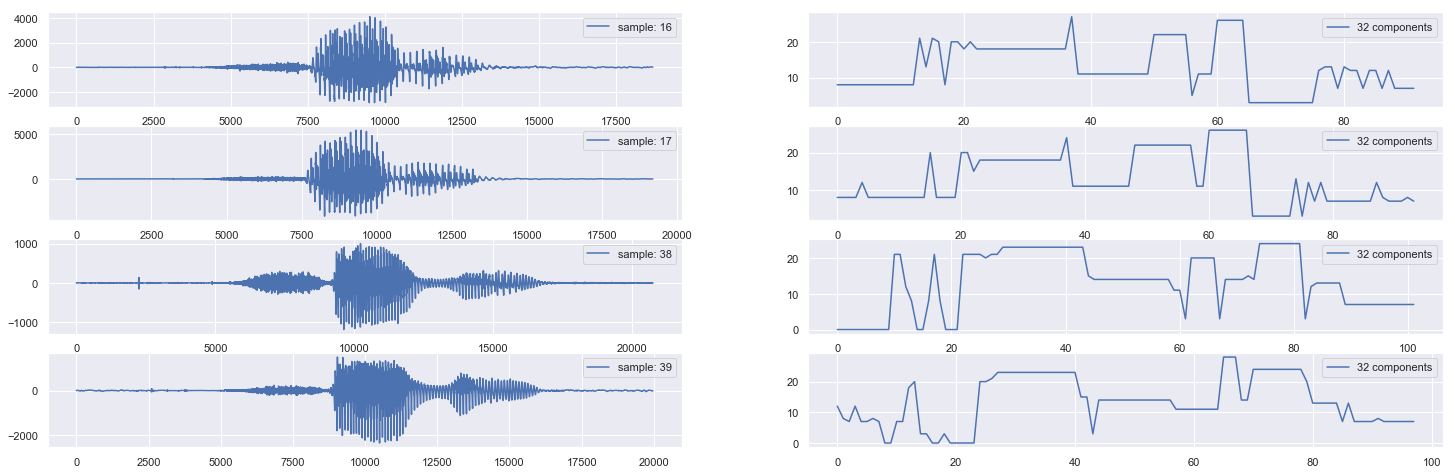

In [196]:
sns.set()
for n_components in [32]:
    gmm = GaussianMixture(n_components = n_components)
    _ = gmm.fit(mfccs)
    i = 1
    _ = plt.rcParams['figure.figsize'] = [25, 8]
    for k in [16,17,38,39]:
        
        ax = plt.subplot(4, 2, i)
        _ = plt.plot(data[k]['samples'], label='sample: %s' % k)
        _ = ax.legend()
        
        mfcc = mfccFn(data[k]['samples'])
        predict = gmm.predict(mfcc)
        ax = plt.subplot(4, 2, i+1)
        labels = tidigit2labels([data[k]])
        _ = plt.plot(predict, label='%s components' % n_components)
        _ = ax.legend()
        
        i += 2

### 7 Comparing Utterances

In [273]:
def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """
    r, c = len(x), len(y)
    D0 = np.zeros((r + 1, c + 1))
    D0[0, 1:] = np.inf
    D0[1:, 0] = np.inf
    acc_dist = D0[1:, 1:] 
    for i in range(r):
        for j in range(c):
            distance = dist(x[i], y[j])
            acc_dist[i, j] = distance
    local_dist = acc_dist.copy()
    for i in range(r):
        for j in range(c):
            acc_dist[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x) == 1:
        path = np.zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), np.zeros(len(x))
    else:
        path = _traceback(D0)
    return acc_dist[-1, -1] / sum(acc_dist.shape), local_dist, acc_dist, path

def _traceback(D):
    i, j = np.array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = np.argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else:
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)

In [275]:
D = np.empty((len(data), len(data)))
dist = lambda x, y: cdist(x.reshape(1,-1), y.reshape(1,-1))
mfcc_1 = mfccs[0]
mfcc_2 = mfccs[1]
print(mfcc_2.reshape(1,-1).shape)
print(D.shape)
print(dist(mfcc_1[0], mfcc_2[0]))
for i in xrange(len(D)):
    for j in xrange(len(D)):
        global_dist, local_dist, acc_dist, path = dtw(mfccs[i], mfccs[j], dist)
        D[i,j] = global_dist

(1, 13)
(44, 44)
[[7.041743]]


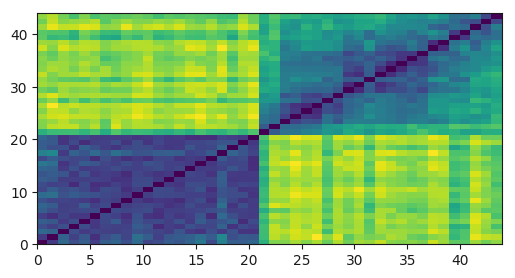

In [276]:
sns.reset_defaults()
_ = plt.rcParams['figure.figsize'] = [6, 3]
_ = plt.pcolormesh(D)

In [256]:
print(data)

[{u'digit': u'o', u'gender': u'man', u'filename': u'/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav', u'samplingrate': 20000, u'speaker': u'bm', u'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16), u'repetition': u'a'}
 {u'digit': u'o', u'gender': u'man', u'filename': u'/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/ob.wav', u'samplingrate': 20000, u'speaker': u'bm', u'samples': array([  0,   0,   4, ..., -14, -12, -11], dtype=int16), u'repetition': u'b'}
 {u'digit': u'z', u'gender': u'man', u'filename': u'/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/za.wav', u'samplingrate': 20000, u'speaker': u'bm', u'samples': array([-1,  0, -3, ...,  0,  0, -2], dtype=int16), u'repetition': u'a'}
 {u'digit': u'z', u'gender': u'man', u'filename': u'/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/zb.wav', u'samplingrate': 20000, u'speaker': u'bm', u'samples': array([ 1, -1, -4, ...,  8,  9,  9], dtype=int16), u'repetition': 

In [283]:
D_linked = linkage(D.T, method='complete')
_ = plt.rcParams['figure.figsize'] = [15, 14]
labels = tidigit2labels(data)
print(labels)

[u'man_bm_o_a', u'man_bm_o_b', u'man_bm_z_a', u'man_bm_z_b', u'man_bm_1_a', u'man_bm_1_b', u'man_bm_2_a', u'man_bm_2_b', u'man_bm_3_a', u'man_bm_3_b', u'man_bm_4_a', u'man_bm_4_b', u'man_bm_5_a', u'man_bm_5_b', u'man_bm_6_a', u'man_bm_6_b', u'man_bm_7_a', u'man_bm_7_b', u'man_bm_8_a', u'man_bm_8_b', u'man_bm_9_a', u'man_bm_9_b', u'woman_ew_o_a', u'woman_ew_o_b', u'woman_ew_z_a', u'woman_ew_z_b', u'woman_ew_1_a', u'woman_ew_1_b', u'woman_ew_2_a', u'woman_ew_2_b', u'woman_ew_3_a', u'woman_ew_3_b', u'woman_ew_4_a', u'woman_ew_4_b', u'woman_ew_5_a', u'woman_ew_5_b', u'woman_ew_6_a', u'woman_ew_6_b', u'woman_ew_7_a', u'woman_ew_7_b', u'woman_ew_8_a', u'woman_ew_8_b', u'woman_ew_9_a', u'woman_ew_9_b']


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


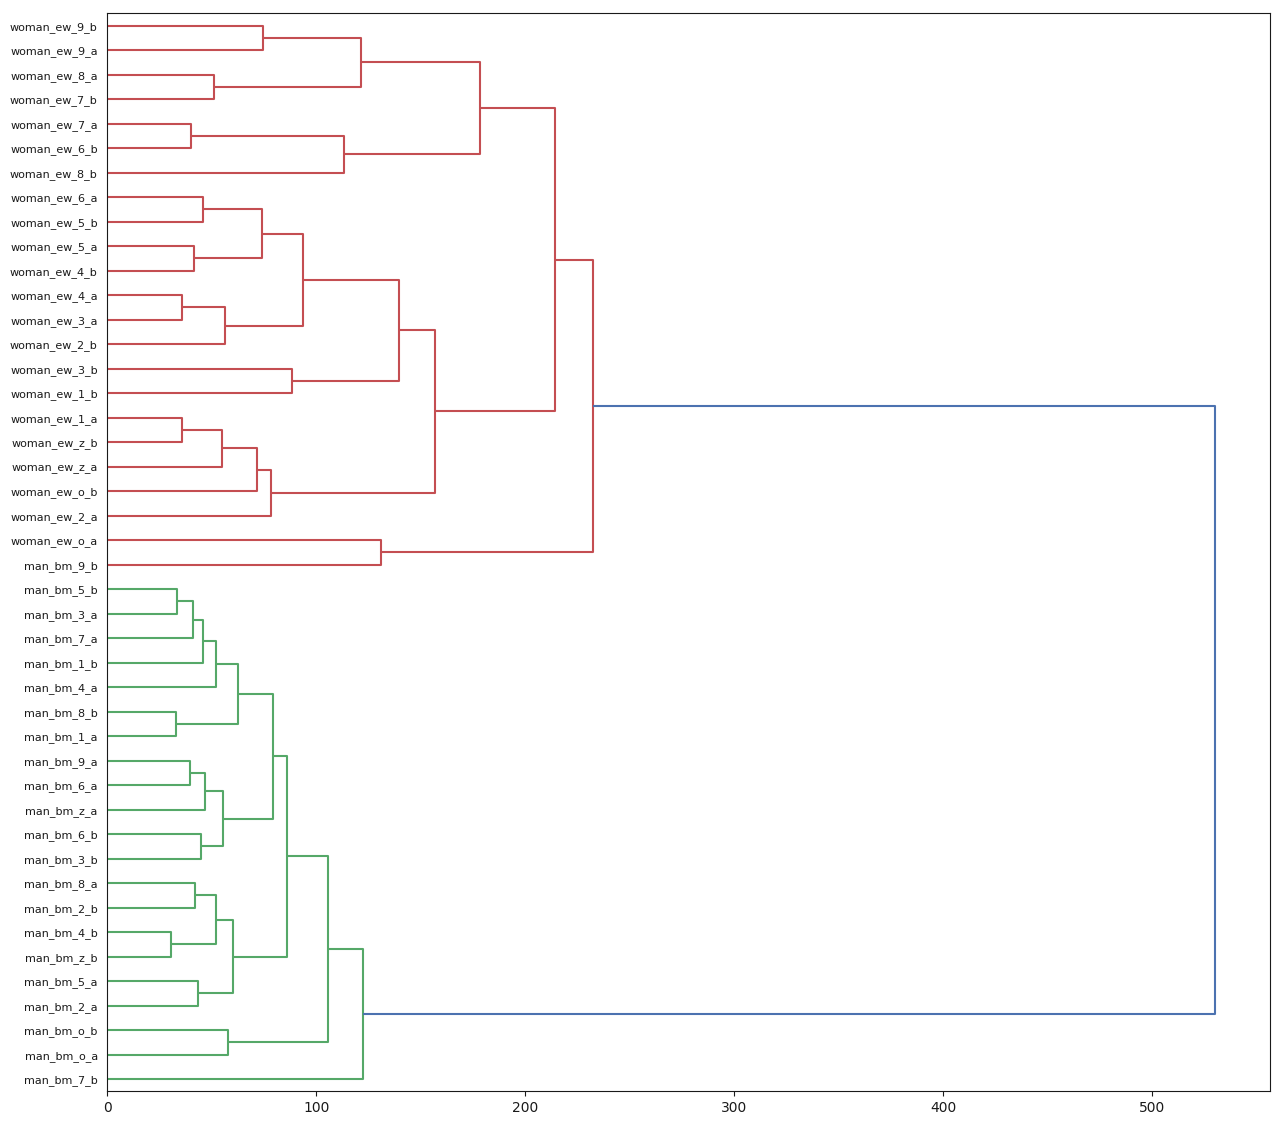

In [284]:
text = dendrogram(D_linked, labels=labels, orientation='right')

In [259]:
text

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'b'],
 'dcoord': [[0.0, 57.6490057814722, 57.6490057814722, 0.0],
  [0.0, 43.17193355263803, 43.17193355263803, 0.0],
  [0.0, 30.375355349648313, 30.375355349648313, 0.0],
  [0.0, 42.09159715941179, 42.09159715941179, 0.0],
  [30.375355349648313,
   51.984167485994604,
   51.984167485994604,
   42.09159715941179],
  [43.17193355263803,
   60.27483706489695,
   60.27483706489695,
   51.984167485994604],
  [0.0, 44.8061183425064, 44.8061183425064, 0.0],
  [0.0, 39.72394185169877, 39.72394185169877, 0.0],
  [0.0, 46.67279051382008, 46.67279051382008, 39.72394185169877],
  [44.8061183425064, 55.2615324106537, 55.2615324106537, 46.67279051382008],
  [0.0, 32.58922329047325, 32.589223290

##### References :  
1. (2019). Download.ni.com. Retrieved 20 April 2019, from http://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf
2. Fayek, H. (2016). Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What’s In-Between. Haytham Fayek. Retrieved 21 April 2019, from https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html